# Lord of the Rings Character Network Analysis
### Yen-Ting Chen

This is an analysis and visualization of the characters network in the Lord of the Rings trilogy. The connections between characters are analyzed based on their correlated appearances in the same scene in the movie scripts.  
The full R code files used in this analysis can be viewed on my <a href="https://github.com/janie128/Random_Projects/tree/master/LOTRCharacters" target="_blank">Github</a>.

First, the lines from the movie scripts for the three films in the trilogy are loaded:

In [5]:
library(dplyr)
library(stringr)
library(tidyr)
library(reshape2)
raw <- readLines("LOTR.txt")
raw2 <- readLines("LOTR2.txt")
raw3 <- readLines("LOTR3.txt")

The raw lines from the script are then parsed to determine when a new scene starts.  
We can achieve this by generating two additional columns: `is_scene`, which is a boolean stating whether or not the current line is the start of a new scene, and `scene`, which is an integer column that keeps track of the current scene number by summing the previous numbers of True `is_scene`.  
The start-of-scene lines are "INT." and "EXT.", so a detection of either of these gives True for `is_scene`.  
Additionally, some lines that are not dialogue or character names (such as camera directions including "WIDE ON:", "TEASING SHOTS:") are filtered out to cut down on the lines that need to be analyzed later.  
The above is done with this function:

In [8]:
readToLinesFn <- function(raw){
  lines <- data_frame(raw=raw) %>% 
    # Filter off non-dialogue, non-character lines
    filter(raw!="", raw!=" ", !str_detect(raw, "SUPER:"), !str_detect(raw,"IMAGE:"),
           !str_detect(raw, "FADE UP:"), !str_detect(raw, "TEASING SHOTS:"),
           !str_detect(raw, "CONTINUED:"), !str_detect(raw, "WIDE ON:"),
           !str_detect(raw, "ANGLE ON:")) %>%
    # Detect where each new scene starts and generate scene number
    mutate(is_scene = (str_detect(raw, "INT\\.") | str_detect(raw, "EXT\\.")),
           scene = cumsum(is_scene))
  lines$is_scene <- NULL
  return(lines)
}

lines <- readToLinesFn(raw)
lines2 <- readToLinesFn(raw2)
lines3 <- readToLinesFn(raw3)

Next, we need to extract character names from the remaining lines in the script.  
Here is a short excerpt from the script for LOTR1.  
>                                                       CUT TO:
>
>EXT. MIDGEWATER MOORS -- DAY
>
>Aerial on: Strider leading Frodo, Sam, Merry, and Pippin  
>across the windswept moors. The hobbits suddenly stop and  
>unstrap their knapsacks.  
>
>                     STRIDER
>          Gentlemen, we do not stop until
>          nightfall.
>
>                    PIPPIN
>          What about breakfast?  
  
Careful observation of the script reveals that the name of the speaking character follows the pattern of:  
a) The line starts with several spaces.  
b) The name is written in all capital letters.  
c) The above two conditions can also lead to directorial instructions such as "CUT TO:" in the first line of the above excerpt. Speaking characters' names must also NOT have the line end with a colon.  
  
With the above patterns, we can use regex search to identify the lines containing the speaking character's name and extract it with the following function: (note the white space in front of the name is stripped once the name is identified)

In [9]:
parseToCharactersFn <- function(lines){
  # Regex search to identify characters
  characterScenes <- lines %>% filter(str_detect(raw, "^ +[A-Z][A-Z]+"))
  characterScenes <- characterScenes %>% filter(str_detect(raw, "[A-Z][A-Z]+$"), !str_detect(raw, ":$"))
  characterScenes$raw <- trimws(characterScenes$raw)
  return(characterScenes)
}

characterScenes <- parseToCharactersFn(lines)
characterScenes2 <- parseToCharactersFn(lines2)
characterScenes3 <- parseToCharactersFn(lines3)

We can then generate the list of unique character names from the above.  
Unfortunately, this method of pattern identifying is not foolproof, and occasional inclusion of a non-character-name line is included. Additionally, there are many characters that are very minor characters within the trilogy and we want to exclude those to have our character network analysis be more focused. This calls for some manual run-through of the list and removal of the unwanted or wrong elements.  
An example is given here for LOTR1:

In [11]:
characterList <- unique(characterScenes$raw)
# manual removal of unwanted/wrong elements
unwanted <- c(characterList[1], characterList[10], characterList[11], characterList[12],
              characterList[13], characterList[14], characterList[15], characterList[17],
              characterList[18], characterList[20], characterList[31], characterList[32],
              characterList[33])
characterList <- characterList[! characterList %in% unwanted]
characterScenes <- characterScenes %>% filter(raw %in% characterList)
rm(unwanted)

Additionally, in LOTR1, the character Aragorn also goes by the name Strider, so we will consolidate the two. While in LOTR3, the names Witch-King and Witch King are used intechangeably.

In [12]:
# Change STRIDER to ARAGORN (same person)
sameNameFn <- function(x){
  gsub("STRIDER", "ARAGORN", x)
}
characterScenes$raw <- sapply(characterScenes$raw, sameNameFn)

# Change WITCH-KING to WITCH KING (same person)
sameNameFn3 <- function(x){
  gsub("WITCH-KING", "WITCH KING", x)
}
characterScenes3$raw <- sapply(characterScenes3$raw, sameNameFn3)

Finally, we are ready to do the clustering analysis of these characters!  
The clustering is based on the correlation of appearance of characters within the same scene.  
For **Lord of the Rings: Fellowship of the Ring**, we can generate the cluster plot of the characters:

Using n as value column: use value.var to override.


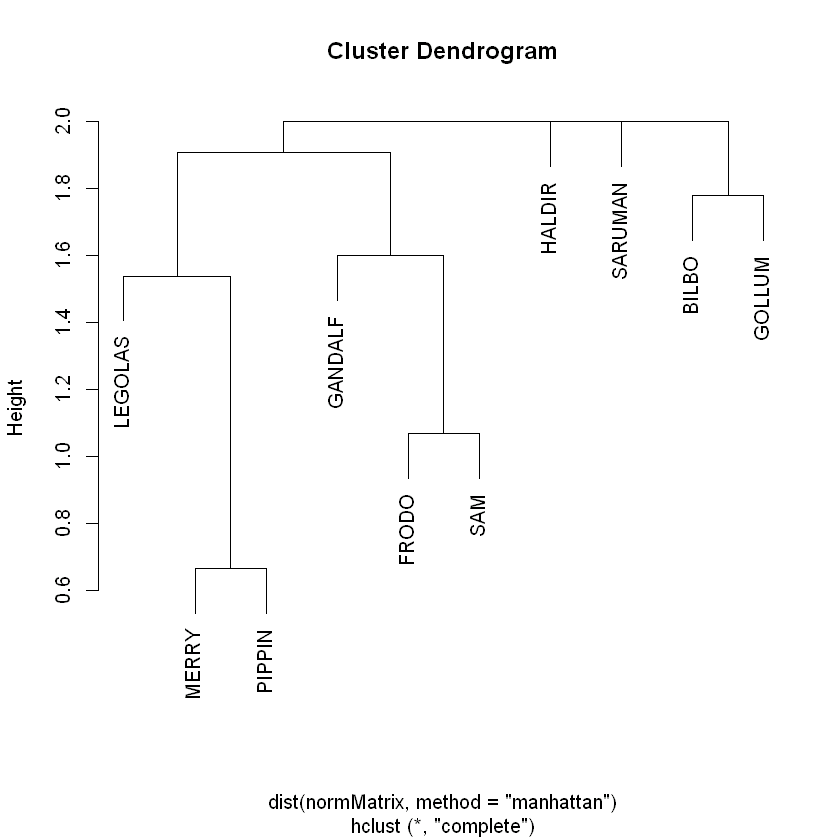

In [13]:
sceneCharacterCount <- characterScenes %>% count(scene,raw)
sceneCharacterMatrix <- sceneCharacterCount %>% acast(raw~scene, fun.aggregate = length)
normMatrix <- sceneCharacterMatrix / rowSums(sceneCharacterMatrix)
characterCluster <- hclust(dist(normMatrix, method="manhattan"))
plot(characterCluster)

--------------------------------------------------------------------------------------------------------------------------------

**Lord of the Rings: The Two Towers**

Using n as value column: use value.var to override.


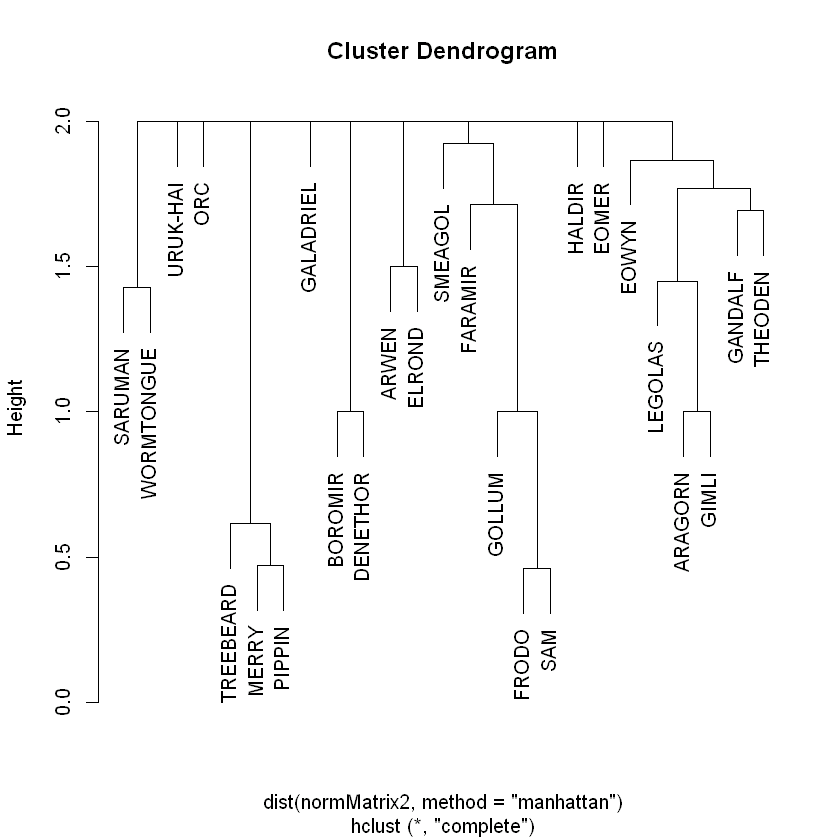

In [14]:
sceneCharacterCount2 <- characterScenes2 %>% count(scene,raw)
sceneCharacterMatrix2 <- sceneCharacterCount2 %>% acast(raw~scene, fun.aggregate = length)
normMatrix2 <- sceneCharacterMatrix2 / rowSums(sceneCharacterMatrix2)
characterCluster2 <- hclust(dist(normMatrix2, method="manhattan"))
plot(characterCluster2)

--------------------------------------------------------------------------------------------------------------------------------

**Lord of the Rings: The Return of the King**

Using n as value column: use value.var to override.


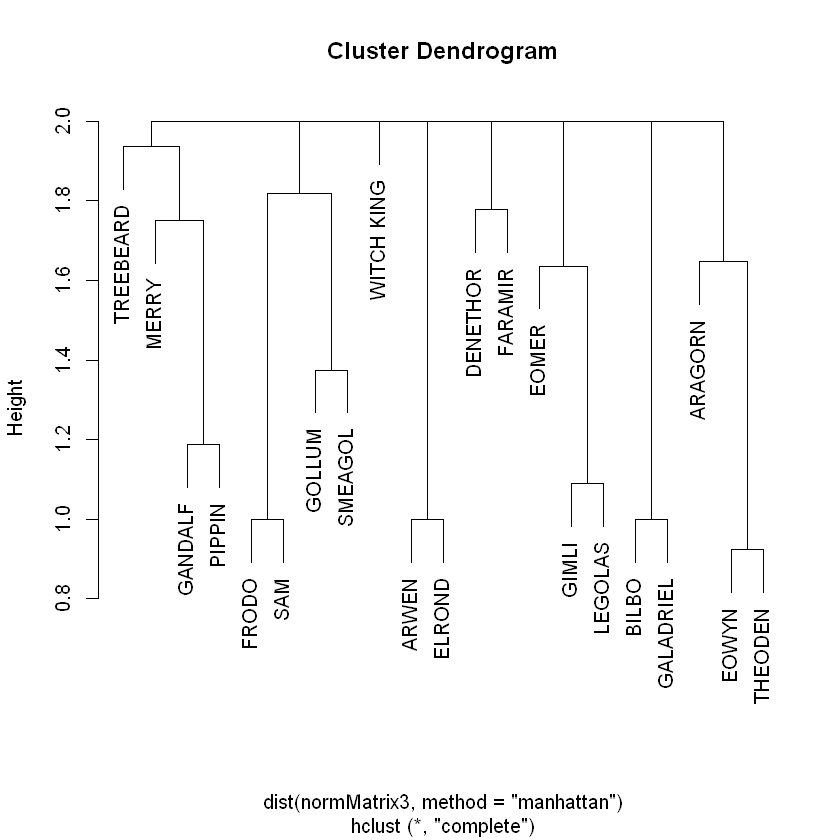

In [15]:
sceneCharacterCount3 <- characterScenes3 %>% count(scene,raw)
sceneCharacterMatrix3 <- sceneCharacterCount3 %>% acast(raw~scene, fun.aggregate = length)
normMatrix3 <- sceneCharacterMatrix3 / rowSums(sceneCharacterMatrix3)
characterCluster3 <- hclust(dist(normMatrix3, method="manhattan"))
plot(characterCluster3)

The grand finale, with all three parts of the **Lord of the Rings Trilogy** together:

Using n as value column: use value.var to override.


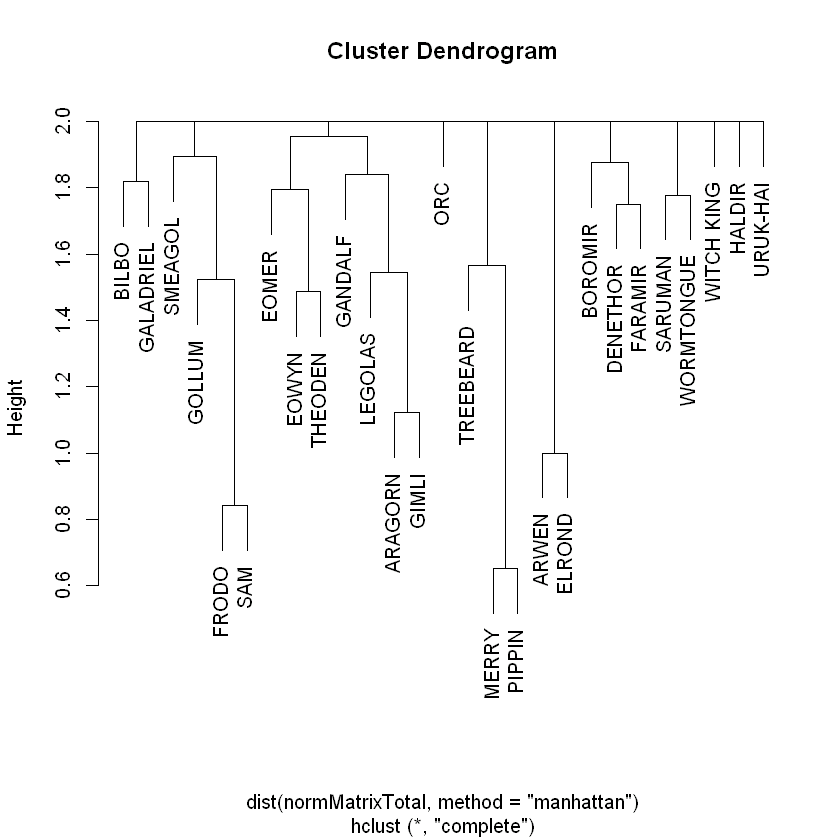

In [16]:
totalSCC <- rbind(sceneCharacterCount, sceneCharacterCount2, sceneCharacterCount3)
end1 <- nrow(sceneCharacterCount)
end2 <- nrow(sceneCharacterCount) + nrow(sceneCharacterCount2)
totalSCC[(end1+1):end2,1] <- sapply(totalSCC[(end1+1):end2,1], function(x) {x+1000})
totalSCC[(end2+1):nrow(totalSCC),1] <- sapply(totalSCC[(end2+1):nrow(totalSCC),1], function(x) {x+2000})


totalSCCMatrix <- totalSCC %>% acast(raw~scene, fun.aggregate = length)
normMatrixTotal <- totalSCCMatrix / rowSums(totalSCCMatrix)
characterClusterTotal <- hclust(dist(normMatrixTotal, method="manhattan"))
plot(characterClusterTotal)

The above analysis, though requiring a bit of pre-knowledge of the characters and some manual cleaning, gives a very good result of visualizing the character network.  
The most strongly related pairs are Merry and Pippin, and Frodo and Sam (also quite correlated with Gollum). This matches a LOTR reader's understanding of the character relationships.

--------------------------------------------------------------------------------------------------------------------------------

#### ** This analysis was based on the blogpost <a href="http://varianceexplained.org/r/love-actually-network/" target="_blank">Analyzing networks of characters in 'Love Actually'</a>.
#### Data Source (movie scripts):
Lord of the Rings: Fellowship of the Ring  
<a href="http://www.imsdb.com/Movie%20Scripts/Lord%20of%20the%20Rings:%20Fellowship%20of%20the%20Ring,%20The%20Script.html" target="_blank">http://www.imsdb.com/Movie%20Scripts/Lord%20of%20the%20Rings:%20Fellowship%20of%20the%20Ring,%20The%20Script.html</a>  
Lord of the Rings: The Two Towers  
<a href="http://www.fempiror.com/otherscripts/LordoftheRings2-TTT.pdf" target="_blank">http://www.fempiror.com/otherscripts/LordoftheRings2-TTT.pdf</a>  
Lord of the Rings: The Return of the King  
<a href="http://www.imsdb.com/Movie%20Scripts/Lord%20of%20the%20Rings:%20Return%20of%20the%20King%20Script.html" target="_blank">http://www.imsdb.com/Movie%20Scripts/Lord%20of%20the%20Rings:%20Return%20of%20the%20King%20Script.html</a>  